In [1]:
!pip list

Package                       Version
----------------------------- ------------
accelerate                    1.0.1
aiohttp                       3.8.6
aiosignal                     1.3.1
alembic                       1.12.0
altair                        5.1.2
annotated-types               0.7.0
anyio                         4.0.0
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asttokens                     2.4.0
async-generator               1.10
async-lru                     2.0.4
async-timeout                 4.0.3
attrs                         23.1.0
automated-interpretability    0.0.6
babe                          0.0.7
Babel                         2.13.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.5
beartype                      0.14.1
beautifulsoup4                4.12.2
better-abc                    0.0.3
bidict                        0.23.1
bleach                        6.1.0
blinker     

# Imports

In [2]:
import torch
import json
import configparser
import huggingface_hub
import pandas as pd
from transformers import AutoTokenizer
from tqdm import tqdm
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint
from transformer_lens.utils import get_act_name
from sae_lens import SAE
import seaborn as sns
import matplotlib.pyplot as plt
from utils.loading_utils import get_pretrained_model

# Constants

In [3]:
DATA_PATH = "./data/com2sense.json"
CONFIG_PATH = "./config.ini"
MODEL_NAME = "gemma-2-2b-it"
N_SHOTS = 5
BATCH_SIZE = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
remote = False
MAX_IDX = 100
LAYERS = "ALL"    # Layers to look at activations, "ALL" or list of int
TOP_K = 100        # Top k activations to look at
torch.set_grad_enabled(False)

print(f"Executing on device {device}")

Executing on device cuda


# Load data

In [4]:
def load_data(n_shots: int, data_path: str, data_key: str = "examples", lookup_key: str = "pair_id_lookup") -> tuple:
    with open(data_path, "r") as file:
        dataset = json.load(file)

    examples = dataset[data_key]
    pair_id_lookup = dataset[lookup_key]
    dataset = pd.DataFrame(examples)
    train = dataset.sample(n_shots)
    test = dataset.drop(train.index)

    return train, test, pair_id_lookup

train, test, pair_id_lookup = load_data(N_SHOTS, DATA_PATH)

# Load model

In [5]:
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

def load_model(model_name: str, device='cpu') -> HookedTransformer:
    print(f"Loading model {model_name}...")
    weights_directory = "./models/" + config[model_name]['weights_directory']
    model = get_pretrained_model(weights_directory, dtype=torch.bfloat16, device=device, verbose=True)
    return model

model = load_model(MODEL_NAME, device=device)
print(model)

Loading model gemma-2-2b-it...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemma2RMSNorm((2304,), eps

After loading HookedTransformer allocated 20.019888877868652 GB cuda memory
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-25): 26 x TransformerBlock(
      (ln1): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln1_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (h

# Obtain layer-level activation for zero-shot CoT vs. non-CoT in residual stream

In [6]:
def get_layer_acts_post_resid(statements, model: HookedTransformer, layers: list) -> dict:
    """
    Get given layer post residual activations for the statements. Activations are obtained after the last token is read.
    args:
        statements: The statements to obtain activations for.
        model: The model to use.
        layers: The layers (int) to obtain activations for as a list.
    returns: dictionary of stacked activations of shape (batch_size, hidden_channels)
    """
    acts = {}
    def get_act(value: torch.Tensor, hook: HookPoint):
        acts[hook.name] = value[:, -1, :]

    hooks = []
    for layer in layers:
        hooks.append((get_act_name("resid_post", layer=layer), get_act))

    _ = model.run_with_hooks(statements, fwd_hooks=hooks, return_type=None)

    return acts

def get_layer_acts_attn(statements, model: HookedTransformer, layers: list) -> tuple:
    """
    Get given layer attention activations for the statements. Activations are obtained after the last token is read.
    args:
        statements: The statements to obtain activations for.
        model: The model to use.
        layers: The layers (int) to obtain activations for as a list.
    returns: tuple of dictionary of stacked q, k, v activations of shape (batch_size, n_attn_heads, d_k(headdim))
    """
    acts_q = {}
    acts_k = {}
    acts_v = {}
    def get_act_q(value: torch.Tensor, hook: HookPoint):
        acts_q[hook.name] = value[:, -1, :, :]
    def get_act_k(value: torch.Tensor, hook: HookPoint):
        acts_k[hook.name] = value[:, -1, :, :]
    def get_act_v(value: torch.Tensor, hook: HookPoint):
        acts_v[hook.name] = value[:, -1, :, :]

    hooks = []
    for layer in layers:
        hooks.append((get_act_name("q", layer=layer), get_act_q))
        hooks.append((get_act_name("k", layer=layer), get_act_k))
        hooks.append((get_act_name("v", layer=layer), get_act_v))

    _ = model.run_with_hooks(statements, fwd_hooks=hooks, return_type=None)

    return acts_q, acts_k, acts_v


def obtain_act_diff(model: HookedTransformer, queries: pd.DataFrame, batch_size: int, exp: str, layers: list, train_prompt: str, prompt_key: str = "sent", max_idx: int = -1) -> tuple:
    """
    Obtains the activation difference between queries and queries + exp.
    args:
        model: The model to use.
        queries: The queries to use.
        batch_size: The batch size to use.
        exp: The prompt to experiment with, added to the end of the sentence.
        layers: The list of layers (int) to obtain diff.
        train_prompt: The prompt used to train the model.
        prompt_key: The key in the queries dataframe that contains the prompt.
        max_idx: The maximum number of queries to use. Set to -1 to use all queries.
    returns:
        The activation difference between the model's predictions for the given queries, original activations, experimental activations.
        tuple<list<map<str, torch.Tensor>>>
    """
    diffs_resid = []
    acts_resid = []
    acts_resid_exp = []
    diffs_q, diffs_k, diffs_v = [], [], []
    acts_q, acts_k, acts_v = [], [], []
    acts_q_exp, acts_k_exp, acts_v_exp = [], [], []
    max_idx = len(queries) if max_idx == -1 else max_idx
    for batch_idx in tqdm(range(0, max_idx, batch_size), desc="Processing batches"):
        batch = queries.iloc[batch_idx : batch_idx + batch_size][prompt_key].tolist()
        batch = [train_prompt + query for query in batch]
        batch_exp = [train_prompt + query + exp for query in batch]

        act_resid = get_layer_acts_post_resid(batch, model, layers)
        act_resid_exp = get_layer_acts_post_resid(batch_exp, model, layers)
        acts_resid.append(act_resid)
        acts_resid_exp.append(act_resid_exp)
        diff_resid = {layer: act_resid_exp[layer] - act_resid[layer] for layer in act_resid.keys()}
        diffs_resid.append(diff_resid)

        # act_q, act_k, act_v = get_layer_acts_attn(batch, model, layers)
        # act_q_exp, act_k_exp, act_v_exp = get_layer_acts_attn(batch_exp, model, layers)
        # diff_q = {layer: act_q_exp[layer] - act_q[layer] for layer in act_q.keys()}
        # diff_k = {layer: act_k_exp[layer] - act_k[layer] for layer in act_k.keys()}
        # diff_v = {layer: act_v_exp[layer] - act_v[layer] for layer in act_v.keys()}
        # diffs_q.append(diff_q)
        # diffs_k.append(diff_k)
        # diffs_v.append(diff_v)
        # acts_q.append(act_q)
        # acts_k.append(act_k)
        # acts_v.append(act_v)
        # acts_q_exp.append(act_q_exp)
        # acts_k_exp.append(act_k_exp)
        # acts_v_exp.append(act_v_exp)

    return diffs_resid, acts_resid, acts_resid_exp # , diffs_q, acts_q, acts_q_exp, diffs_k, acts_k, acts_k_exp, diffs_v, acts_v, acts_v_exp

layers = list(range(len(model.blocks))) if LAYERS == "ALL" else LAYERS
diffs_resid, acts_resid, acts_resid_exp = obtain_act_diff(model, test, 1, " let's think step by step", layers, "Is it true that ", max_idx=MAX_IDX)

Processing batches: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


In [7]:
print(len(diffs_resid))
print(diffs_resid[0].keys())
print(diffs_resid[0]["blocks.0.hook_resid_post"].shape)

100
dict_keys(['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post', 'blocks.4.hook_resid_post', 'blocks.5.hook_resid_post', 'blocks.6.hook_resid_post', 'blocks.7.hook_resid_post', 'blocks.8.hook_resid_post', 'blocks.9.hook_resid_post', 'blocks.10.hook_resid_post', 'blocks.11.hook_resid_post', 'blocks.12.hook_resid_post', 'blocks.13.hook_resid_post', 'blocks.14.hook_resid_post', 'blocks.15.hook_resid_post', 'blocks.16.hook_resid_post', 'blocks.17.hook_resid_post', 'blocks.18.hook_resid_post', 'blocks.19.hook_resid_post', 'blocks.20.hook_resid_post', 'blocks.21.hook_resid_post', 'blocks.22.hook_resid_post', 'blocks.23.hook_resid_post', 'blocks.24.hook_resid_post', 'blocks.25.hook_resid_post'])
torch.Size([1, 2304])


# Look at direction mean and std of CoT vs. Non-CoT

Transform dict into tensor

In [8]:
diffs_resid = torch.stack([torch.stack([diffs_resid[i][layer] for layer in diffs_resid[i].keys()]) for i in range(len(diffs_resid))])
# diffs_q = torch.stack([torch.stack([diffs_q[i][layer] for layer in diffs_q[i].keys()]) for i in range(len(diffs_q))])
# diffs_k = torch.stack([torch.stack([diffs_k[i][layer] for layer in diffs_k[i].keys()]) for i in range(len(diffs_k))])
# diffs_v = torch.stack([torch.stack([diffs_v[i][layer] for layer in diffs_v[i].keys()]) for i in range(len(diffs_v))])

In [9]:
acts_resid = torch.stack([torch.stack([acts_resid[i][layer] for layer in acts_resid[i].keys()]) for i in range(len(acts_resid))])
acts_exp_resid = torch.stack([torch.stack([acts_resid_exp[i][layer] for layer in acts_resid_exp[i].keys()]) for i in range(len(acts_resid_exp))])
# acts_q = torch.stack([torch.stack([acts_q[i][layer] for layer in acts_q[i].keys()]) for i in range(len(acts_q))])
# acts_q_exp = torch.stack([torch.stack([acts_q_exp[i][layer] for layer in acts_q_exp[i].keys()]) for i in range(len(acts_q_exp))])
# acts_k = torch.stack([torch.stack([acts_k[i][layer] for layer in acts_k[i].keys()]) for i in range(len(acts_k))])
# acts_k_exp = torch.stack([torch.stack([acts_k_exp[i][layer] for layer in acts_k_exp[i].keys()]) for i in range(len(acts_k_exp))])
# acts_v = torch.stack([torch.stack([acts_v[i][layer] for layer in acts_v[i].keys()]) for i in range(len(acts_v))])
# acts_v_exp = torch.stack([torch.stack([acts_v_exp[i][layer] for layer in acts_v_exp[i].keys()]) for i in range(len(acts_v_exp))])

Remove sequence dimension as we are only looking at the last token

In [10]:
diffs_resid = diffs_resid[:, :, 0, :]
acts_resid = acts_resid[:, :, 0, :]
acts_exp_resid = acts_exp_resid[:, :, 0, :]

In [11]:
print(diffs_resid.shape)
print(acts_resid.shape)
print(acts_exp_resid.shape)
# print(diffs_q.shape)
# print(diffs_k.shape)
# print(diffs_v.shape)

torch.Size([100, 26, 2304])
torch.Size([100, 26, 2304])
torch.Size([100, 26, 2304])


In [12]:
mean_diffs_resid = torch.mean(diffs_resid, dim=0)
std_diffs_resid = torch.std(diffs_resid, dim=0)
mean_exp_resid = torch.mean(acts_exp_resid, dim=0)
std_exp_resid = torch.std(acts_exp_resid, dim=0)
mean_resid = torch.mean(acts_resid, dim=0)
std_resid = torch.std(acts_resid, dim=0)

In [13]:
print(mean_diffs_resid.shape)
print(std_diffs_resid.shape)

torch.Size([26, 2304])
torch.Size([26, 2304])


# Save activations and difference data

In case we want to analyze neurons with SAEs in the future

In [14]:
torch.save(diffs_resid, "./experimental_data/diffs_resid.pt")
torch.save(acts_resid, "./experimental_data/acts_resid.pt")
torch.save(acts_exp_resid, "./experimental_data/acts_exp_resid.pt")

In [15]:
def print_mean_std(array: torch.Tensor):
    """
    Prints the mean and standard deviation of the array.
    args:
        array: The array to print the mean and standard deviation of.
    """
    for i in range(array.shape[0]):
        print(f"Layer {i}")
        # print(f"mean: {mean_diffs_resid[i]}")
        # print(f"std: {std_diffs_resid[i]}")
        print(f"mean std: {torch.mean(array[i])}")

print_mean_std(std_exp_resid)
print_mean_std(std_resid)

Layer 0
mean std: 0.14678196609020233
Layer 1
mean std: 0.19593924283981323
Layer 2
mean std: 0.20076915621757507
Layer 3
mean std: 0.20449474453926086
Layer 4
mean std: 0.22250601649284363
Layer 5
mean std: 0.26305559277534485
Layer 6
mean std: 0.2845054268836975
Layer 7
mean std: 0.3574441969394684
Layer 8
mean std: 0.4177705943584442
Layer 9
mean std: 0.49123647809028625
Layer 10
mean std: 0.5271249413490295
Layer 11
mean std: 0.6391690373420715
Layer 12
mean std: 0.660879373550415
Layer 13
mean std: 0.7121050953865051
Layer 14
mean std: 0.7254889607429504
Layer 15
mean std: 0.7344975471496582
Layer 16
mean std: 0.8657227158546448
Layer 17
mean std: 0.8469061255455017
Layer 18
mean std: 0.9193686246871948
Layer 19
mean std: 0.9910923838615417
Layer 20
mean std: 1.0331255197525024
Layer 21
mean std: 1.184163212776184
Layer 22
mean std: 1.3696539402008057
Layer 23
mean std: 1.506941795349121
Layer 24
mean std: 1.7739827632904053
Layer 25
mean std: 2.608480215072632
Layer 0
mean std: 0

Seems like the activations of CoT have smaller std than that of vanilla prompts

# Find CoT related activations by averaging out irrelevant features

In [16]:
def get_min_std_indeces(std_resid: torch.Tensor, k: int):
    """
    Gets the indices of the minimum standard deviation for each layer.
    args:
        std_resid: The standard deviation of the activations.
        k: Top k minimum standard deviations to return.
    returns:
        The indices of the minimum standard deviation for each layer.
    """
    indeces = []
    for i in range(std_resid.shape[0]):
        indeces_layer_i = torch.argsort(std_resid[i, :], dim=0, descending=False)[:k]
        indeces.append(indeces_layer_i)
    indeces = torch.stack(indeces)
    return indeces

cot_diffs_indeces = get_min_std_indeces(std_diffs_resid, TOP_K)
cot_exp_indeces = get_min_std_indeces(std_exp_resid, TOP_K)
cot_indeces = get_min_std_indeces(std_resid, TOP_K)

Look at experimental run min std neurons at each layer

In [17]:
print(cot_exp_indeces)
std_exp_resid_top_k = torch.gather(std_exp_resid, 1, cot_exp_indeces)
print(std_exp_resid_top_k)

tensor([[1527, 1467, 1166,  ..., 1628,  257,  853],
        [1312, 1685, 1161,  ...,  944, 2050, 1086],
        [1102, 1591, 1024,  ...,  319,  257,  152],
        ...,
        [ 854, 1905,  304,  ..., 2115,   16,  649],
        [ 908,  304, 1612,  ...,  539, 2274,  486],
        [1005, 1402,  504,  ...,  175, 1255,  499]], device='cuda:0')
tensor([[0.0641, 0.0663, 0.0667,  ..., 0.0899, 0.0900, 0.0900],
        [0.0980, 0.1007, 0.1034,  ..., 0.1298, 0.1299, 0.1300],
        [0.1073, 0.1082, 0.1085,  ..., 0.1342, 0.1343, 0.1344],
        ...,
        [0.5296, 0.5815, 0.5843,  ..., 0.9602, 0.9642, 0.9649],
        [0.7572, 0.8015, 0.8147,  ..., 1.1739, 1.1747, 1.1749],
        [1.4352, 1.5336, 1.5358,  ..., 1.9697, 1.9713, 1.9713]],
       device='cuda:0')


In [18]:
std_resid_top_k = torch.gather(std_resid, 1, cot_indeces)

# Let's visualize these data

### std

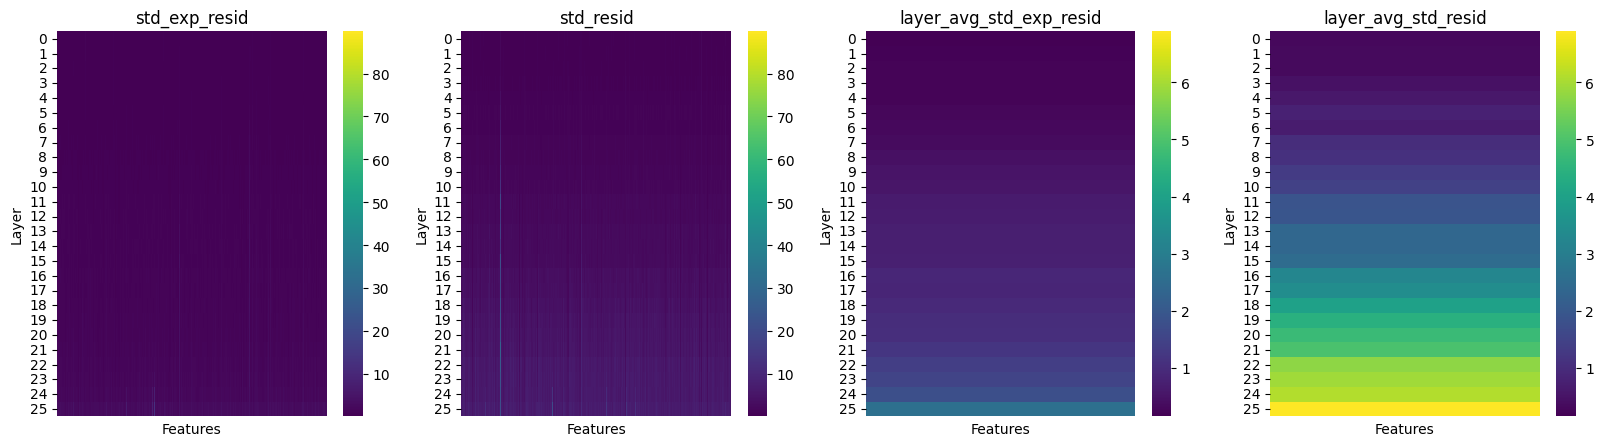

In [19]:
def draw_heatmap(tensor: torch.Tensor, title: str, axis=None, vmin=None, vmax=None):
    """
    Draws a heatmap of the tensor.
    args:
        tensor: The tensor to draw the heatmap of. Must have dimensionality of 2
        title: The title of the heatmap.
        axis: The axis to draw the heatmap on (for side-by-side plots), default to None if not needed
        vmin: The minimum value to draw on heatmap, defaults to None
        vmax: The maximum value to draw on heatmap, defaults to None
    """
    data = tensor.to(torch.float32).cpu().numpy()
    sns.heatmap(data, cmap='viridis', cbar=True, xticklabels=False, yticklabels=True, ax=axis, vmin=vmin, vmax=vmax)

    ax = axis if axis is not None else plt.gca()
    ax.set_xlabel('Features')
    ax.set_ylabel('Layer')
    ax.set_title(title)

layer_avg_std_exp_resid = torch.mean(std_exp_resid, dim=1).unsqueeze(1)
layer_avg_std_resid = torch.mean(std_resid, dim=1).unsqueeze(1)
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
vmin = torch.min(torch.min(std_exp_resid), torch.min(std_resid))
vmax = torch.max(torch.max(std_exp_resid), torch.max(std_resid))
draw_heatmap(std_exp_resid, "std_exp_resid", axes[0], vmin=vmin, vmax=vmax)
draw_heatmap(std_resid, "std_resid", axes[1], vmin=vmin, vmax=vmax)
vmin = torch.min(torch.min(layer_avg_std_exp_resid), torch.min(layer_avg_std_resid))
vmax = torch.max(torch.max(layer_avg_std_exp_resid), torch.max(layer_avg_std_resid))
draw_heatmap(layer_avg_std_exp_resid, "layer_avg_std_exp_resid", axes[2], vmin=vmin, vmax=vmax)
draw_heatmap(layer_avg_std_resid, "layer_avg_std_resid", axes[3], vmin=vmin, vmax=vmax)
plt.show()

It seems like the middle layers have higher std for non-CoT. We can also notice a feature with very high std at the last layer for CoT.

Looking at the mean of std at each layer, it seems like our claim can be verified. It is possible that non-CoT started retrieving knowledge in earlier layers, maybe CoT neuron lies in the earlier layers such that non-CoT is not signaled with CoT and therefore started retrieving knowledge earlier. This is consistent with our findings on llama-3.2-1b:
![](./figs/llama-3.2-1b-std_resid_comp.png)

### mean

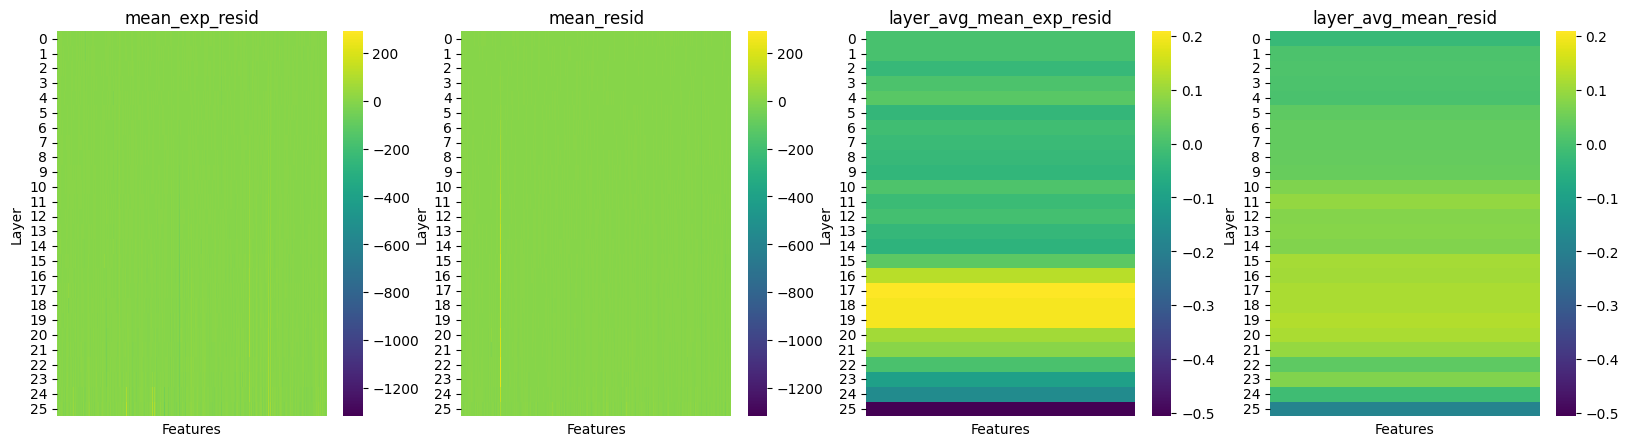

In [20]:
layer_avg_mean_exp_resid = torch.mean(mean_exp_resid, dim=1).unsqueeze(1)
layer_avg_mean_resid = torch.mean(mean_resid, dim=1).unsqueeze(1)
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
vmin = torch.min(torch.min(mean_exp_resid), torch.min(mean_resid))
vmax = torch.max(torch.max(mean_exp_resid), torch.max(mean_resid))
draw_heatmap(mean_exp_resid, "mean_exp_resid", axes[0], vmin=vmin, vmax=vmax)
draw_heatmap(mean_resid, "mean_resid", axes[1], vmin=vmin, vmax=vmax)
vmin = torch.min(torch.min(layer_avg_mean_exp_resid), torch.min(layer_avg_mean_resid))
vmax = torch.max(torch.max(layer_avg_mean_exp_resid), torch.max(layer_avg_mean_resid))
draw_heatmap(layer_avg_mean_exp_resid, "layer_avg_mean_exp_resid", axes[2], vmin=vmin, vmax=vmax)
draw_heatmap(layer_avg_mean_resid, "layer_avg_mean_resid", axes[3], vmin=vmin, vmax=vmax)
plt.show()

Means of Non-CoT gets smaller per layer, while Non-CoT jumps back-and-forth across different layers. It is worth noticing that Non-CoT gets much smaller compared to CoT down the layers. This could be due to retierval of knowledge in early layers that guided misinformation which propagated down the pipeline, whereas CoT does not attempt to retrieve all the information at once. Activations from gemma-2-2b-it is slightly different from our observations on llama-3.2-1b. However, gemma-2-2b-it also have a concentrated high-mean area around its mid to later layers Below are results from llama-3.2-1b
![](./figs/llama-3.2-1b-mean_resid_comp.png)

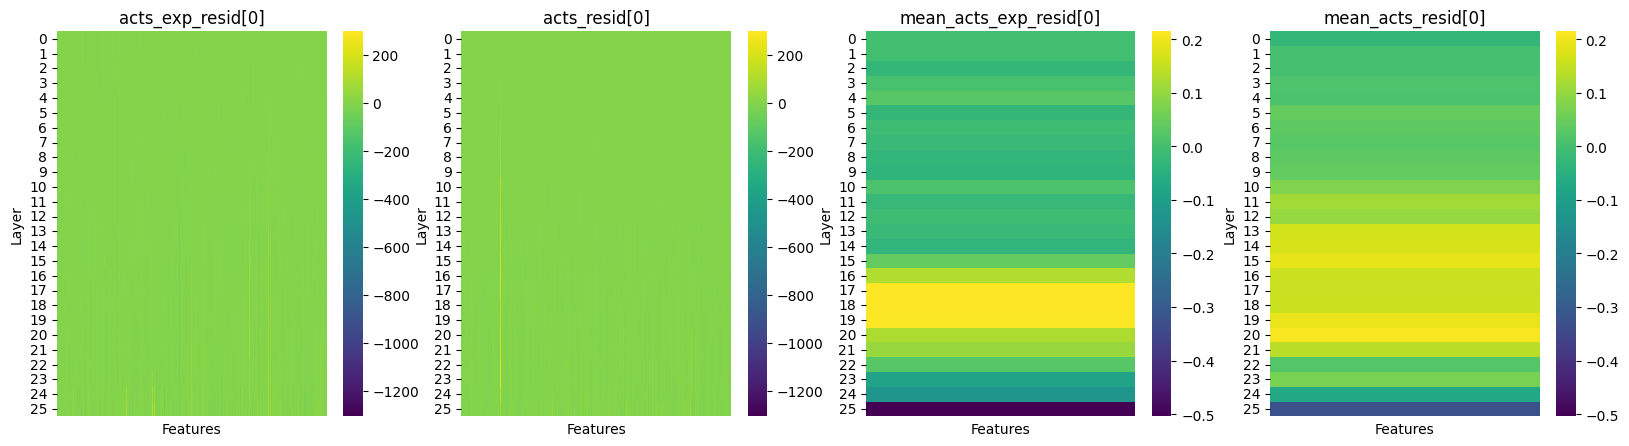

In [21]:
mean_acts_exp_resid = torch.mean(acts_exp_resid[0], dim=1).unsqueeze(1)
mean_acts_resid = torch.mean(acts_resid[0], dim=1).unsqueeze(1)
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
vmin = torch.min(torch.min(acts_exp_resid[0]), torch.min(acts_resid[0]))
vmax = torch.max(torch.max(acts_exp_resid[0]), torch.max(acts_resid[0]))
draw_heatmap(acts_exp_resid[0], "acts_exp_resid[0]", axes[0], vmin=vmin, vmax=vmax)
draw_heatmap(acts_resid[0], "acts_resid[0]", axes[1], vmin=vmin, vmax=vmax)
vmin = torch.min(torch.min(mean_acts_exp_resid), torch.min(mean_acts_resid))
vmax = torch.max(torch.max(mean_acts_exp_resid), torch.max(mean_acts_resid))
draw_heatmap(mean_acts_exp_resid, "mean_acts_exp_resid[0]", axes[2], vmin=vmin, vmax=vmax)
draw_heatmap(mean_acts_resid, "mean_acts_resid[0]", axes[3], vmin=vmin, vmax=vmax)
plt.show()

Seems to be true for one example. In particular, layers 9 to 12 have very small mean, in which I suspect contains important neurons related to CoT or directed by CoT. Since CoT only make one-step reasoning each time, these layers could be verifying its hypothesis.